In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
import gensim
import glob2
from itertools import chain
import os
import numpy as np
import itertools
import cPickle as pickle
from  scipy.stats import rankdata
import copy
from openpyxl import Workbook
from openpyxl.compat import range
from openpyxl.utils import get_column_letter
from openpyxl import load_workbook
import pandas as pd
from scipy.stats import hmean
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize


2018-04-10 18:25:29,376 : INFO : 'pattern' package not found; tag filters are not available for English


In [3]:
# ignores everything except english alphabet and  
def only_alphabet(text):
    return ''.join(i for i in text if (ord(i)<123 and ord(i)>96) or (ord(i)<91 and ord(i)>64) or ord(i)==32) 

In [4]:
full_filenames = []
x= ['LegalAdhocTask/ConsumerCourtAdhocdata/DCDRC/**/*.txt','LegalAdhocTask/ConsumerCourtAdhocdata/NCDRC/**/*.txt','LegalAdhocTask/ConsumerCourtAdhocdata/SCDRC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/DelhiHC/**/*.txt','LegalAdhocTask/SC-HCAdhocData/JharkhandHC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/JodhpurHC/**/*.txt' ,'LegalAdhocTask/SC-HCAdhocData/KolkataHC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/SupremeCourt/**/*.txt']
for glob_filenames in x:
    glob_filenames = os.path.normpath(glob_filenames)
    for filename in sorted(glob2.glob(glob_filenames)):
        full_filenames.append(filename)
            
filenames = []
x= ['LegalAdhocTask/ConsumerCourtAdhocdata/DCDRC/**/*.txt','LegalAdhocTask/ConsumerCourtAdhocdata/NCDRC/**/*.txt','LegalAdhocTask/ConsumerCourtAdhocdata/SCDRC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/DelhiHC/**/*.txt','LegalAdhocTask/SC-HCAdhocData/JharkhandHC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/JodhpurHC/**/*.txt' ,'LegalAdhocTask/SC-HCAdhocData/KolkataHC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/SupremeCourt/**/*.txt']
for glob_filenames in x:
    glob_filenames = os.path.normpath(glob_filenames)
    for filename in sorted(glob2.glob(glob_filenames)):
        filenames.append(os.path.basename(filename))

en_stop = set(get_stop_words('en'))
ps = PorterStemmer()

# "yield" for each file return token list  i.e list of lists
def files_to_tokens(glob_filenames):
    glob_filenames = os.path.normpath(glob_filenames)
    for filename in sorted(glob2.glob(glob_filenames)):
        f = open(filename)
        # read the whole file as lowercase string
        string = only_alphabet(f.read()).lower()
        tokens = []
        # tokenize that string
        for word in word_tokenize(string):
            if word not in en_stop:
                tokens.append(ps.stem(word))

        yield tokens
        f.close()


        
# yields token list for files specific to courts; needed for creating dictionaries
class texts:
    def DCDRC(self):
        for text in files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/DCDRC/*.txt'):
            yield text
    def NCDRC(self):
        for text in files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/NCDRC/**/*.txt'):
            yield text
    def SCDRC(self):
        for text in files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/SCDRC/**/*.txt'):
            yield text
    def DelhiHC(self):
        for text in files_to_tokens('LegalAdhocTask/SC-HCAdhocData/DelhiHC/**/*.txt'):
            yield text
    def JharkhandHC(self):
        for text in files_to_tokens('LegalAdhocTask/SC-HCAdhocData/JharkhandHC/**/*.txt'):
            yield text
    def JodhpurHC(self):
        for text in  files_to_tokens('LegalAdhocTask/SC-HCAdhocData/JodhpurHC/**/*.txt'):
            yield text
    def KolkataHC(self):
        for text in  files_to_tokens('LegalAdhocTask/SC-HCAdhocData/KolkataHC/**/*.txt'):
            yield text
    def SupremeCourt(self):
        for text in  files_to_tokens('LegalAdhocTask/SC-HCAdhocData/SupremeCourt/**/*.txt'):
            yield text
    def everything(self):
        return chain(self.DCDRC(), self.NCDRC(), self.SCDRC(), self.DelhiHC(),
                     self.JharkhandHC(), self.JodhpurHC(), self.KolkataHC(), self.SupremeCourt())
        
# yields bow for each file - tuples id,fq ; needed to train models   
class my_corpus:    
    def DCDRC(self):
        for text in files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/DCDRC/*.txt'):
            yield dictionary.doc2bow(text)
    def NCDRC(self):
        for text in files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/NCDRC/**/*.txt'):
            yield dictionary.doc2bow(text)            
    def SCDRC(self):
        for text in files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/SCDRC/**/*.txt'):
            yield dictionary.doc2bow(text)
    def DelhiHC(self):
        for text in files_to_tokens('LegalAdhocTask/SC-HCAdhocData/DelhiHC/**/*.txt'):
            yield dictionary.doc2bow(text)
    def JharkhandHC(self):
        for text in files_to_tokens('LegalAdhocTask/SC-HCAdhocData/JharkhandHC/**/*.txt'):
            yield dictionary.doc2bow(text)
    def JodhpurHC(self):
        for text in  files_to_tokens('LegalAdhocTask/SC-HCAdhocData/JodhpurHC/**/*.txt'):
            yield dictionary.doc2bow(text)
    def KolkataHC(self):
        for text in  files_to_tokens('LegalAdhocTask/SC-HCAdhocData/KolkataHC/**/*.txt'):
            yield dictionary.doc2bow(text)
    def SupremeCourt(self):
        for text in  files_to_tokens('LegalAdhocTask/SC-HCAdhocData/SupremeCourt/**/*.txt'):
            yield dictionary.doc2bow(text)
    def everything(self):
        return chain(self.DCDRC(), self.NCDRC(), self.SCDRC(), self.DelhiHC(),
                     self.JharkhandHC(), self.JodhpurHC(), self.KolkataHC(), self.SupremeCourt())
        
        

In [5]:
#################################### laod the dictinary
dictionary = corpora.Dictionary.load('stem100_dictionary')

2018-04-10 18:25:52,144 : INFO : loading Dictionary object from stem100_dictionary
2018-04-10 18:25:52,323 : INFO : loaded stem100_dictionary


In [6]:
######################################## load BOW
corpus = corpora.MmCorpus('stem100.mm')

2018-04-10 18:25:52,459 : INFO : loaded corpus index from stem100.mm.index
2018-04-10 18:25:52,459 : INFO : initializing corpus reader from stem100.mm
2018-04-10 18:25:52,488 : INFO : accepted corpus with 351985 documents, 40069 features, 92572684 non-zero entries


In [7]:
# %%time

# c = texts()
# count = 0
# for x in c.everything():
#     x = [ i for i in x if i in dictionary.token2id]
#     with open(os.path.normpath('Token_corpus/' + str(count)), 'wb') as fp:
#         pickle.dump(x, fp)
#     count=count+1


In [8]:
def token_corpus(i):
    with open (os.path.normpath('Token_corpus/' + str(i)), 'rb') as fp:
            itemlist = pickle.load(fp)
            return itemlist   

In [9]:
from gensim.models.doc2vec import TaggedDocument

In [10]:
class iter_token_corpus:
    def __iter__(self):
        for i in xrange(0, 351985):
            with open (os.path.normpath('Token_corpus/' + str(i)), 'rb') as fp:
                itemlist = pickle.load(fp)
                yield TaggedDocument(itemlist, [i])

In [11]:
%%time
model = gensim.models.Doc2Vec(iter_token_corpus(), sample=.00001, size=300, window=10, negative=5, hs=0, min_count=0, workers=8, iter=20)

2018-04-10 18:25:52,834 : INFO : collecting all words and their counts
2018-04-10 18:25:52,907 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2018-04-10 18:26:05,898 : INFO : PROGRESS: at example #10000, processed 11872635 words (913980/s), 28140 word types, 10000 tags
2018-04-10 18:26:16,254 : INFO : PROGRESS: at example #20000, processed 22389436 words (1015605/s), 31281 word types, 20000 tags
2018-04-10 18:26:25,927 : INFO : PROGRESS: at example #30000, processed 32260628 words (1020568/s), 32838 word types, 30000 tags
2018-04-10 18:26:33,729 : INFO : PROGRESS: at example #40000, processed 40518216 words (1058471/s), 34451 word types, 40000 tags
2018-04-10 18:26:41,680 : INFO : PROGRESS: at example #50000, processed 47137590 words (832556/s), 35170 word types, 50000 tags
2018-04-10 18:26:48,086 : INFO : PROGRESS: at example #60000, processed 53235450 words (951987/s), 36026 word types, 60000 tags
2018-04-10 18:26:53,495 : INFO : PROGRESS: at example 

2018-04-10 18:30:48,682 : INFO : PROGRESS: at 0.21% examples, 160887 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:30:49,698 : INFO : PROGRESS: at 0.21% examples, 162347 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:30:50,705 : INFO : PROGRESS: at 0.22% examples, 163016 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:30:51,710 : INFO : PROGRESS: at 0.23% examples, 164275 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:30:52,738 : INFO : PROGRESS: at 0.24% examples, 162130 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:30:53,749 : INFO : PROGRESS: at 0.25% examples, 162665 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:30:54,751 : INFO : PROGRESS: at 0.26% examples, 163399 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:30:55,762 : INFO : PROGRESS: at 0.27% examples, 163551 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:30:56,775 : INFO : PROGRESS: at 0.28% examples, 163994 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:30:57,784 : INFO : PROGRESS: at 0.29% examples, 164003 words/s, in_q

2018-04-10 18:32:10,395 : INFO : PROGRESS: at 1.24% examples, 177718 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:32:11,405 : INFO : PROGRESS: at 1.26% examples, 177870 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:32:12,409 : INFO : PROGRESS: at 1.27% examples, 178126 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:32:13,415 : INFO : PROGRESS: at 1.28% examples, 178098 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:32:14,425 : INFO : PROGRESS: at 1.28% examples, 178071 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:32:15,433 : INFO : PROGRESS: at 1.29% examples, 178068 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:32:16,434 : INFO : PROGRESS: at 1.30% examples, 178237 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:32:17,436 : INFO : PROGRESS: at 1.31% examples, 178304 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:32:18,451 : INFO : PROGRESS: at 1.33% examples, 178507 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:32:19,466 : INFO : PROGRESS: at 1.34% examples, 178508 words/s, in_q

2018-04-10 18:33:32,039 : INFO : PROGRESS: at 2.41% examples, 187146 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:33:33,048 : INFO : PROGRESS: at 2.42% examples, 187158 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:33:34,052 : INFO : PROGRESS: at 2.43% examples, 187208 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:33:35,053 : INFO : PROGRESS: at 2.45% examples, 187233 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:33:36,060 : INFO : PROGRESS: at 2.47% examples, 187268 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:33:37,068 : INFO : PROGRESS: at 2.48% examples, 187396 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:33:38,073 : INFO : PROGRESS: at 2.49% examples, 187480 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:33:39,085 : INFO : PROGRESS: at 2.50% examples, 187455 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:33:40,098 : INFO : PROGRESS: at 2.52% examples, 187515 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:33:41,112 : INFO : PROGRESS: at 2.54% examples, 187580 words/s, in_q

2018-04-10 18:34:53,629 : INFO : PROGRESS: at 3.44% examples, 187876 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:34:54,636 : INFO : PROGRESS: at 3.49% examples, 187704 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:34:55,651 : INFO : PROGRESS: at 3.54% examples, 187561 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:34:56,657 : INFO : PROGRESS: at 3.57% examples, 187486 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:34:57,675 : INFO : PROGRESS: at 3.63% examples, 187344 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:34:58,687 : INFO : PROGRESS: at 3.70% examples, 187199 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:34:59,701 : INFO : PROGRESS: at 3.77% examples, 187009 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:35:00,709 : INFO : PROGRESS: at 3.83% examples, 186837 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:35:01,725 : INFO : PROGRESS: at 3.87% examples, 186744 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:35:02,734 : INFO : PROGRESS: at 3.92% examples, 186645 words/s, in_q

2018-04-10 18:36:15,287 : INFO : PROGRESS: at 4.79% examples, 188520 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:36:16,298 : INFO : PROGRESS: at 4.80% examples, 188525 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:36:17,299 : INFO : PROGRESS: at 4.81% examples, 188528 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:36:18,303 : INFO : PROGRESS: at 4.81% examples, 188522 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:36:19,309 : INFO : PROGRESS: at 4.82% examples, 188491 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:36:20,315 : INFO : PROGRESS: at 4.83% examples, 188470 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:36:21,327 : INFO : PROGRESS: at 4.83% examples, 188477 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:36:22,338 : INFO : PROGRESS: at 4.84% examples, 188437 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:36:23,344 : INFO : PROGRESS: at 4.85% examples, 188418 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:36:24,347 : INFO : PROGRESS: at 4.85% examples, 188405 words/s, in_q

2018-04-10 18:37:36,848 : INFO : PROGRESS: at 5.47% examples, 186107 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:37:37,849 : INFO : PROGRESS: at 5.49% examples, 186100 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:37:38,857 : INFO : PROGRESS: at 5.49% examples, 186079 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:37:39,865 : INFO : PROGRESS: at 5.50% examples, 186138 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:37:40,866 : INFO : PROGRESS: at 5.50% examples, 186209 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:37:41,870 : INFO : PROGRESS: at 5.52% examples, 186227 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:37:42,930 : INFO : PROGRESS: at 5.53% examples, 186201 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:37:43,933 : INFO : PROGRESS: at 5.55% examples, 186207 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:37:44,948 : INFO : PROGRESS: at 5.55% examples, 186171 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:37:45,950 : INFO : PROGRESS: at 5.57% examples, 186106 words/s, in_q

2018-04-10 18:38:58,545 : INFO : PROGRESS: at 6.47% examples, 184579 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:38:59,566 : INFO : PROGRESS: at 6.48% examples, 184608 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:39:00,576 : INFO : PROGRESS: at 6.49% examples, 184583 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:39:01,580 : INFO : PROGRESS: at 6.50% examples, 184556 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:39:02,597 : INFO : PROGRESS: at 6.51% examples, 184527 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:39:03,608 : INFO : PROGRESS: at 6.52% examples, 184500 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:39:04,608 : INFO : PROGRESS: at 6.53% examples, 184509 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:39:05,616 : INFO : PROGRESS: at 6.54% examples, 184525 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:39:06,620 : INFO : PROGRESS: at 6.55% examples, 184504 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:39:07,626 : INFO : PROGRESS: at 6.56% examples, 184488 words/s, in_q

2018-04-10 18:40:20,704 : INFO : PROGRESS: at 7.63% examples, 184820 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:40:21,708 : INFO : PROGRESS: at 7.64% examples, 184826 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:40:22,720 : INFO : PROGRESS: at 7.65% examples, 184812 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:40:23,723 : INFO : PROGRESS: at 7.65% examples, 184802 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:40:24,724 : INFO : PROGRESS: at 7.66% examples, 184817 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:40:25,732 : INFO : PROGRESS: at 7.67% examples, 184822 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:40:26,737 : INFO : PROGRESS: at 7.68% examples, 184813 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:40:27,749 : INFO : PROGRESS: at 7.69% examples, 184836 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:40:28,759 : INFO : PROGRESS: at 7.69% examples, 184874 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:40:29,767 : INFO : PROGRESS: at 7.70% examples, 184961 words/s, in_q

2018-04-10 18:41:42,384 : INFO : PROGRESS: at 9.12% examples, 183869 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:41:43,388 : INFO : PROGRESS: at 9.15% examples, 183907 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:41:44,393 : INFO : PROGRESS: at 9.17% examples, 183924 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:41:45,402 : INFO : PROGRESS: at 9.19% examples, 183958 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:41:46,416 : INFO : PROGRESS: at 9.21% examples, 183981 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:41:47,430 : INFO : PROGRESS: at 9.24% examples, 184012 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:41:48,436 : INFO : PROGRESS: at 9.27% examples, 184042 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:41:49,439 : INFO : PROGRESS: at 9.29% examples, 184072 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:41:50,443 : INFO : PROGRESS: at 9.32% examples, 184097 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:41:51,458 : INFO : PROGRESS: at 9.34% examples, 184137 words/s, in_q

2018-04-10 18:43:04,067 : INFO : PROGRESS: at 9.87% examples, 184756 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:43:05,075 : INFO : PROGRESS: at 9.88% examples, 184761 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:43:06,083 : INFO : PROGRESS: at 9.88% examples, 184753 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:43:07,085 : INFO : PROGRESS: at 9.89% examples, 184756 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:43:08,091 : INFO : PROGRESS: at 9.90% examples, 184768 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:43:09,094 : INFO : PROGRESS: at 9.90% examples, 184738 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:43:10,100 : INFO : PROGRESS: at 9.91% examples, 184704 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:43:11,103 : INFO : PROGRESS: at 9.92% examples, 184689 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:43:12,111 : INFO : PROGRESS: at 9.93% examples, 184685 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:43:13,125 : INFO : PROGRESS: at 9.94% examples, 184692 words/s, in_q

2018-04-10 18:44:24,790 : INFO : PROGRESS: at 10.64% examples, 184251 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:44:25,791 : INFO : PROGRESS: at 10.65% examples, 184213 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:44:26,800 : INFO : PROGRESS: at 10.67% examples, 184204 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:44:27,806 : INFO : PROGRESS: at 10.68% examples, 184202 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:44:28,818 : INFO : PROGRESS: at 10.68% examples, 184203 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:44:29,848 : INFO : PROGRESS: at 10.69% examples, 184165 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:44:30,849 : INFO : PROGRESS: at 10.70% examples, 184041 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:44:31,869 : INFO : PROGRESS: at 10.70% examples, 183956 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:44:32,878 : INFO : PROGRESS: at 10.72% examples, 183958 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:44:33,879 : INFO : PROGRESS: at 10.73% examples, 183989 wor

2018-04-10 18:45:46,116 : INFO : PROGRESS: at 11.67% examples, 184017 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:45:47,125 : INFO : PROGRESS: at 11.69% examples, 184021 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:45:48,134 : INFO : PROGRESS: at 11.70% examples, 184024 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:45:49,137 : INFO : PROGRESS: at 11.72% examples, 184023 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:45:50,141 : INFO : PROGRESS: at 11.73% examples, 184015 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:45:51,148 : INFO : PROGRESS: at 11.74% examples, 184004 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:45:52,158 : INFO : PROGRESS: at 11.75% examples, 184008 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:45:53,171 : INFO : PROGRESS: at 11.76% examples, 184038 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:45:54,185 : INFO : PROGRESS: at 11.77% examples, 184082 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:45:55,189 : INFO : PROGRESS: at 11.79% examples, 184121 wor

2018-04-10 18:47:06,787 : INFO : PROGRESS: at 12.80% examples, 185865 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:47:07,788 : INFO : PROGRESS: at 12.81% examples, 185874 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:47:08,792 : INFO : PROGRESS: at 12.82% examples, 185869 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:47:09,793 : INFO : PROGRESS: at 12.82% examples, 185885 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:47:10,813 : INFO : PROGRESS: at 12.83% examples, 185898 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:47:11,826 : INFO : PROGRESS: at 12.84% examples, 185893 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:47:12,828 : INFO : PROGRESS: at 12.84% examples, 185905 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:47:13,828 : INFO : PROGRESS: at 12.86% examples, 185901 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:47:14,836 : INFO : PROGRESS: at 12.86% examples, 185913 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:47:15,840 : INFO : PROGRESS: at 12.87% examples, 185922 wor

2018-04-10 18:48:29,813 : INFO : PROGRESS: at 14.28% examples, 182471 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:48:30,860 : INFO : PROGRESS: at 14.28% examples, 182302 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:48:31,995 : INFO : PROGRESS: at 14.29% examples, 182134 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:48:33,099 : INFO : PROGRESS: at 14.29% examples, 181967 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:48:34,299 : INFO : PROGRESS: at 14.29% examples, 181786 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:48:35,304 : INFO : PROGRESS: at 14.29% examples, 181630 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:48:36,384 : INFO : PROGRESS: at 14.30% examples, 181468 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:48:37,405 : INFO : PROGRESS: at 14.30% examples, 181313 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:48:38,669 : INFO : PROGRESS: at 14.30% examples, 181121 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:48:39,740 : INFO : PROGRESS: at 14.30% examples, 180956 wor

2018-04-10 18:49:53,597 : INFO : PROGRESS: at 14.73% examples, 178487 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:49:54,602 : INFO : PROGRESS: at 14.73% examples, 178453 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:49:55,610 : INFO : PROGRESS: at 14.74% examples, 178443 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:49:56,614 : INFO : PROGRESS: at 14.74% examples, 178430 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:49:57,624 : INFO : PROGRESS: at 14.75% examples, 178418 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:49:58,631 : INFO : PROGRESS: at 14.76% examples, 178407 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:49:59,634 : INFO : PROGRESS: at 14.77% examples, 178395 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:50:00,646 : INFO : PROGRESS: at 14.78% examples, 178393 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:50:01,647 : INFO : PROGRESS: at 14.79% examples, 178394 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:50:02,659 : INFO : PROGRESS: at 14.79% examples, 178393 wor

2018-04-10 18:51:14,281 : INFO : PROGRESS: at 15.28% examples, 177028 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:51:15,286 : INFO : PROGRESS: at 15.29% examples, 177004 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:51:16,299 : INFO : PROGRESS: at 15.30% examples, 176973 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:51:17,319 : INFO : PROGRESS: at 15.31% examples, 176941 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:51:18,332 : INFO : PROGRESS: at 15.32% examples, 176892 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:51:19,340 : INFO : PROGRESS: at 15.32% examples, 176859 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:51:20,356 : INFO : PROGRESS: at 15.33% examples, 176835 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:51:21,498 : INFO : PROGRESS: at 15.33% examples, 176776 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:51:22,564 : INFO : PROGRESS: at 15.34% examples, 176710 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:51:23,568 : INFO : PROGRESS: at 15.35% examples, 176694 wor

2018-04-10 18:52:35,234 : INFO : PROGRESS: at 16.20% examples, 176013 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:52:36,242 : INFO : PROGRESS: at 16.21% examples, 175996 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:52:37,253 : INFO : PROGRESS: at 16.22% examples, 176001 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:52:38,274 : INFO : PROGRESS: at 16.23% examples, 176003 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:52:39,283 : INFO : PROGRESS: at 16.25% examples, 175991 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:52:40,286 : INFO : PROGRESS: at 16.26% examples, 175991 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:52:41,302 : INFO : PROGRESS: at 16.27% examples, 175979 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:52:42,312 : INFO : PROGRESS: at 16.28% examples, 175963 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:52:43,324 : INFO : PROGRESS: at 16.28% examples, 175945 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:52:44,325 : INFO : PROGRESS: at 16.29% examples, 175927 wor

2018-04-10 18:53:56,661 : INFO : PROGRESS: at 17.15% examples, 175417 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:53:57,672 : INFO : PROGRESS: at 17.16% examples, 175517 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:53:58,685 : INFO : PROGRESS: at 17.19% examples, 175521 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:53:59,696 : INFO : PROGRESS: at 17.20% examples, 175566 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:54:00,699 : INFO : PROGRESS: at 17.22% examples, 175638 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:54:01,703 : INFO : PROGRESS: at 17.23% examples, 175644 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:54:02,704 : INFO : PROGRESS: at 17.24% examples, 175649 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:54:03,711 : INFO : PROGRESS: at 17.25% examples, 175647 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:54:04,717 : INFO : PROGRESS: at 17.27% examples, 175641 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:54:05,723 : INFO : PROGRESS: at 17.29% examples, 175648 wor

2018-04-10 18:55:17,409 : INFO : PROGRESS: at 17.93% examples, 175168 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:55:18,416 : INFO : PROGRESS: at 17.94% examples, 175165 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:55:19,422 : INFO : PROGRESS: at 17.95% examples, 175156 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:55:20,493 : INFO : PROGRESS: at 17.96% examples, 175139 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:55:21,506 : INFO : PROGRESS: at 17.97% examples, 175133 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:55:22,515 : INFO : PROGRESS: at 17.97% examples, 175128 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:55:23,526 : INFO : PROGRESS: at 17.98% examples, 175130 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:55:24,535 : INFO : PROGRESS: at 17.99% examples, 175130 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:55:25,544 : INFO : PROGRESS: at 17.99% examples, 175123 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:55:26,558 : INFO : PROGRESS: at 18.00% examples, 175109 wor

2018-04-10 18:56:38,298 : INFO : PROGRESS: at 19.60% examples, 174532 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:56:39,303 : INFO : PROGRESS: at 19.60% examples, 174532 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:56:40,310 : INFO : PROGRESS: at 19.60% examples, 174524 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:56:41,321 : INFO : PROGRESS: at 19.61% examples, 174521 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:56:42,325 : INFO : PROGRESS: at 19.61% examples, 174519 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:56:43,343 : INFO : PROGRESS: at 19.62% examples, 174517 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:56:44,354 : INFO : PROGRESS: at 19.62% examples, 174504 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:56:45,359 : INFO : PROGRESS: at 19.62% examples, 174498 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:56:46,369 : INFO : PROGRESS: at 19.63% examples, 174495 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:56:47,390 : INFO : PROGRESS: at 19.63% examples, 174483 wor

2018-04-10 18:57:59,145 : INFO : PROGRESS: at 19.99% examples, 173784 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:58:00,159 : INFO : PROGRESS: at 20.00% examples, 173779 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:58:01,170 : INFO : PROGRESS: at 20.00% examples, 173756 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:58:02,173 : INFO : PROGRESS: at 20.01% examples, 173707 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:58:03,176 : INFO : PROGRESS: at 20.01% examples, 173666 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:58:04,179 : INFO : PROGRESS: at 20.03% examples, 173637 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:58:05,191 : INFO : PROGRESS: at 20.03% examples, 173595 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:58:06,202 : INFO : PROGRESS: at 20.05% examples, 173588 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:58:07,252 : INFO : PROGRESS: at 20.06% examples, 173573 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:58:08,265 : INFO : PROGRESS: at 20.06% examples, 173566 wor

2018-04-10 18:59:19,954 : INFO : PROGRESS: at 20.70% examples, 172759 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:59:20,960 : INFO : PROGRESS: at 20.71% examples, 172730 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:59:21,967 : INFO : PROGRESS: at 20.72% examples, 172731 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:59:22,981 : INFO : PROGRESS: at 20.73% examples, 172730 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:59:23,986 : INFO : PROGRESS: at 20.75% examples, 172730 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:59:24,991 : INFO : PROGRESS: at 20.76% examples, 172708 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:59:26,003 : INFO : PROGRESS: at 20.78% examples, 172705 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:59:27,038 : INFO : PROGRESS: at 20.78% examples, 172701 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:59:28,050 : INFO : PROGRESS: at 20.80% examples, 172691 words/s, in_qsize 0, out_qsize 0
2018-04-10 18:59:29,060 : INFO : PROGRESS: at 20.81% examples, 172697 wor

2018-04-10 19:00:41,144 : INFO : PROGRESS: at 21.62% examples, 172396 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:00:42,154 : INFO : PROGRESS: at 21.64% examples, 172361 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:00:43,166 : INFO : PROGRESS: at 21.66% examples, 172353 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:00:44,178 : INFO : PROGRESS: at 21.67% examples, 172351 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:00:45,185 : INFO : PROGRESS: at 21.68% examples, 172339 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:00:46,188 : INFO : PROGRESS: at 21.70% examples, 172326 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:00:47,201 : INFO : PROGRESS: at 21.71% examples, 172307 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:00:48,203 : INFO : PROGRESS: at 21.72% examples, 172285 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:00:49,211 : INFO : PROGRESS: at 21.73% examples, 172277 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:00:50,325 : INFO : PROGRESS: at 21.74% examples, 172258 wor

2018-04-10 19:02:01,924 : INFO : PROGRESS: at 22.67% examples, 172434 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:02:02,926 : INFO : PROGRESS: at 22.68% examples, 172430 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:02:03,926 : INFO : PROGRESS: at 22.69% examples, 172421 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:02:04,932 : INFO : PROGRESS: at 22.69% examples, 172417 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:02:05,954 : INFO : PROGRESS: at 22.70% examples, 172437 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:02:06,960 : INFO : PROGRESS: at 22.70% examples, 172436 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:02:07,988 : INFO : PROGRESS: at 22.71% examples, 172421 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:02:08,988 : INFO : PROGRESS: at 22.72% examples, 172409 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:02:10,000 : INFO : PROGRESS: at 22.72% examples, 172397 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:02:11,006 : INFO : PROGRESS: at 22.73% examples, 172397 wor

2018-04-10 19:03:22,665 : INFO : PROGRESS: at 23.93% examples, 171869 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:03:23,678 : INFO : PROGRESS: at 23.97% examples, 171849 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:03:24,693 : INFO : PROGRESS: at 24.02% examples, 171828 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:03:25,708 : INFO : PROGRESS: at 24.07% examples, 171802 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:03:26,718 : INFO : PROGRESS: at 24.11% examples, 171791 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:03:27,727 : INFO : PROGRESS: at 24.13% examples, 171797 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:03:28,741 : INFO : PROGRESS: at 24.15% examples, 171800 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:03:29,754 : INFO : PROGRESS: at 24.17% examples, 171809 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:03:30,761 : INFO : PROGRESS: at 24.19% examples, 171809 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:03:31,763 : INFO : PROGRESS: at 24.21% examples, 171818 wor

2018-04-10 19:04:43,563 : INFO : PROGRESS: at 24.76% examples, 171681 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:04:44,949 : INFO : PROGRESS: at 24.76% examples, 171584 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:04:45,962 : INFO : PROGRESS: at 24.77% examples, 171555 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:04:46,966 : INFO : PROGRESS: at 24.78% examples, 171552 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:04:47,969 : INFO : PROGRESS: at 24.79% examples, 171548 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:04:48,981 : INFO : PROGRESS: at 24.79% examples, 171533 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:04:49,987 : INFO : PROGRESS: at 24.80% examples, 171521 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:04:50,988 : INFO : PROGRESS: at 24.80% examples, 171523 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:04:51,997 : INFO : PROGRESS: at 24.81% examples, 171517 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:04:53,013 : INFO : PROGRESS: at 24.81% examples, 171497 wor

2018-04-10 19:06:05,367 : INFO : PROGRESS: at 25.30% examples, 170777 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:06:06,373 : INFO : PROGRESS: at 25.31% examples, 170761 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:06:07,405 : INFO : PROGRESS: at 25.32% examples, 170747 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:06:08,412 : INFO : PROGRESS: at 25.33% examples, 170733 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:06:09,420 : INFO : PROGRESS: at 25.33% examples, 170723 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:06:10,467 : INFO : PROGRESS: at 25.34% examples, 170697 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:06:11,468 : INFO : PROGRESS: at 25.34% examples, 170673 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:06:12,469 : INFO : PROGRESS: at 25.35% examples, 170673 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:06:13,479 : INFO : PROGRESS: at 25.36% examples, 170673 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:06:14,492 : INFO : PROGRESS: at 25.38% examples, 170669 wor

2018-04-10 19:07:26,214 : INFO : PROGRESS: at 26.20% examples, 170230 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:07:27,224 : INFO : PROGRESS: at 26.21% examples, 170236 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:07:28,240 : INFO : PROGRESS: at 26.22% examples, 170245 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:07:29,403 : INFO : PROGRESS: at 26.23% examples, 170240 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:07:30,407 : INFO : PROGRESS: at 26.25% examples, 170242 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:07:31,414 : INFO : PROGRESS: at 26.26% examples, 170252 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:07:32,420 : INFO : PROGRESS: at 26.27% examples, 170254 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:07:33,427 : INFO : PROGRESS: at 26.28% examples, 170246 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:07:34,434 : INFO : PROGRESS: at 26.29% examples, 170241 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:07:35,438 : INFO : PROGRESS: at 26.30% examples, 170240 wor

2018-04-10 19:08:47,091 : INFO : PROGRESS: at 27.22% examples, 170559 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:08:48,109 : INFO : PROGRESS: at 27.23% examples, 170566 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:08:49,115 : INFO : PROGRESS: at 27.24% examples, 170572 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:08:50,123 : INFO : PROGRESS: at 27.25% examples, 170576 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:08:51,126 : INFO : PROGRESS: at 27.27% examples, 170578 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:08:52,137 : INFO : PROGRESS: at 27.29% examples, 170580 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:08:53,141 : INFO : PROGRESS: at 27.30% examples, 170585 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:08:54,156 : INFO : PROGRESS: at 27.31% examples, 170589 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:08:55,166 : INFO : PROGRESS: at 27.32% examples, 170597 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:08:56,188 : INFO : PROGRESS: at 27.33% examples, 170600 wor

2018-04-10 19:10:09,095 : INFO : PROGRESS: at 27.84% examples, 169166 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:10:10,122 : INFO : PROGRESS: at 27.84% examples, 169105 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:10:11,127 : INFO : PROGRESS: at 27.85% examples, 169091 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:10:12,140 : INFO : PROGRESS: at 27.86% examples, 169080 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:10:13,152 : INFO : PROGRESS: at 27.86% examples, 169074 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:10:14,157 : INFO : PROGRESS: at 27.87% examples, 169049 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:10:15,165 : INFO : PROGRESS: at 27.87% examples, 169038 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:10:16,165 : INFO : PROGRESS: at 27.88% examples, 169049 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:10:17,170 : INFO : PROGRESS: at 27.89% examples, 169054 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:10:18,182 : INFO : PROGRESS: at 27.90% examples, 169061 wor

2018-04-10 19:11:32,582 : INFO : PROGRESS: at 29.26% examples, 167689 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:11:33,587 : INFO : PROGRESS: at 29.29% examples, 167707 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:11:34,587 : INFO : PROGRESS: at 29.32% examples, 167724 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:11:35,598 : INFO : PROGRESS: at 29.34% examples, 167743 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:11:36,599 : INFO : PROGRESS: at 29.36% examples, 167759 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:11:37,609 : INFO : PROGRESS: at 29.38% examples, 167784 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:11:38,614 : INFO : PROGRESS: at 29.40% examples, 167809 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:11:39,617 : INFO : PROGRESS: at 29.41% examples, 167839 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:11:40,621 : INFO : PROGRESS: at 29.43% examples, 167866 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:11:41,636 : INFO : PROGRESS: at 29.45% examples, 167889 wor

2018-04-10 19:12:53,225 : INFO : PROGRESS: at 29.91% examples, 168466 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:12:54,233 : INFO : PROGRESS: at 29.92% examples, 168476 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:12:55,234 : INFO : PROGRESS: at 29.93% examples, 168486 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:12:56,237 : INFO : PROGRESS: at 29.94% examples, 168494 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:12:57,237 : INFO : PROGRESS: at 29.95% examples, 168503 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:12:58,241 : INFO : PROGRESS: at 29.96% examples, 168514 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:12:59,248 : INFO : PROGRESS: at 29.96% examples, 168525 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:13:00,253 : INFO : PROGRESS: at 29.97% examples, 168539 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:13:01,260 : INFO : PROGRESS: at 29.98% examples, 168548 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:13:02,272 : INFO : PROGRESS: at 29.98% examples, 168560 wor

2018-04-10 19:14:13,829 : INFO : PROGRESS: at 30.78% examples, 169153 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:14:14,832 : INFO : PROGRESS: at 30.79% examples, 169169 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:14:15,835 : INFO : PROGRESS: at 30.80% examples, 169181 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:14:16,837 : INFO : PROGRESS: at 30.82% examples, 169195 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:14:17,839 : INFO : PROGRESS: at 30.83% examples, 169207 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:14:18,850 : INFO : PROGRESS: at 30.85% examples, 169222 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:14:19,855 : INFO : PROGRESS: at 30.87% examples, 169232 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:14:20,862 : INFO : PROGRESS: at 30.89% examples, 169242 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:14:21,875 : INFO : PROGRESS: at 30.91% examples, 169254 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:14:22,879 : INFO : PROGRESS: at 30.93% examples, 169270 wor

2018-04-10 19:15:34,509 : INFO : PROGRESS: at 31.78% examples, 169450 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:15:35,517 : INFO : PROGRESS: at 31.79% examples, 169466 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:15:36,520 : INFO : PROGRESS: at 31.80% examples, 169477 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:15:37,524 : INFO : PROGRESS: at 31.82% examples, 169483 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:15:38,534 : INFO : PROGRESS: at 31.83% examples, 169485 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:15:39,534 : INFO : PROGRESS: at 31.85% examples, 169491 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:15:40,545 : INFO : PROGRESS: at 31.88% examples, 169500 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:15:41,556 : INFO : PROGRESS: at 31.90% examples, 169505 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:15:42,568 : INFO : PROGRESS: at 31.92% examples, 169513 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:15:43,572 : INFO : PROGRESS: at 31.95% examples, 169522 wor

2018-04-10 19:16:55,144 : INFO : PROGRESS: at 32.85% examples, 170391 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:16:56,145 : INFO : PROGRESS: at 32.86% examples, 170395 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:16:57,158 : INFO : PROGRESS: at 32.86% examples, 170406 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:16:58,163 : INFO : PROGRESS: at 32.87% examples, 170419 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:16:59,177 : INFO : PROGRESS: at 32.88% examples, 170432 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:17:00,193 : INFO : PROGRESS: at 32.89% examples, 170439 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:17:01,216 : INFO : PROGRESS: at 32.90% examples, 170438 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:17:02,217 : INFO : PROGRESS: at 32.91% examples, 170429 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:17:03,222 : INFO : PROGRESS: at 32.91% examples, 170442 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:17:04,223 : INFO : PROGRESS: at 32.92% examples, 170450 wor

2018-04-10 19:18:15,829 : INFO : PROGRESS: at 34.61% examples, 171087 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:18:16,840 : INFO : PROGRESS: at 34.61% examples, 171096 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:18:17,850 : INFO : PROGRESS: at 34.62% examples, 171105 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:18:18,854 : INFO : PROGRESS: at 34.62% examples, 171113 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:18:19,866 : INFO : PROGRESS: at 34.63% examples, 171123 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:18:20,875 : INFO : PROGRESS: at 34.63% examples, 171133 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:18:21,877 : INFO : PROGRESS: at 34.64% examples, 171138 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:18:22,883 : INFO : PROGRESS: at 34.64% examples, 171149 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:18:23,886 : INFO : PROGRESS: at 34.65% examples, 171150 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:18:24,895 : INFO : PROGRESS: at 34.65% examples, 171154 wor

2018-04-10 19:19:36,485 : INFO : PROGRESS: at 35.13% examples, 171515 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:19:37,491 : INFO : PROGRESS: at 35.14% examples, 171521 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:19:38,505 : INFO : PROGRESS: at 35.14% examples, 171526 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:19:39,507 : INFO : PROGRESS: at 35.15% examples, 171536 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:19:40,517 : INFO : PROGRESS: at 35.17% examples, 171537 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:19:41,527 : INFO : PROGRESS: at 35.17% examples, 171532 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:19:42,534 : INFO : PROGRESS: at 35.18% examples, 171529 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:19:43,543 : INFO : PROGRESS: at 35.19% examples, 171532 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:19:44,549 : INFO : PROGRESS: at 35.20% examples, 171541 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:19:45,553 : INFO : PROGRESS: at 35.21% examples, 171547 wor

2018-04-10 19:20:57,852 : INFO : PROGRESS: at 36.14% examples, 171837 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:20:58,856 : INFO : PROGRESS: at 36.15% examples, 171841 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:20:59,865 : INFO : PROGRESS: at 36.16% examples, 171854 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:21:00,870 : INFO : PROGRESS: at 36.18% examples, 171867 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:21:01,874 : INFO : PROGRESS: at 36.19% examples, 171878 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:21:02,880 : INFO : PROGRESS: at 36.20% examples, 171890 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:21:03,886 : INFO : PROGRESS: at 36.22% examples, 171901 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:21:04,908 : INFO : PROGRESS: at 36.23% examples, 171913 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:21:05,912 : INFO : PROGRESS: at 36.25% examples, 171922 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:21:06,919 : INFO : PROGRESS: at 36.26% examples, 171930 wor

2018-04-10 19:22:18,398 : INFO : PROGRESS: at 37.34% examples, 172895 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:22:19,405 : INFO : PROGRESS: at 37.35% examples, 172900 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:22:20,409 : INFO : PROGRESS: at 37.37% examples, 172904 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:22:21,417 : INFO : PROGRESS: at 37.39% examples, 172906 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:22:22,421 : INFO : PROGRESS: at 37.41% examples, 172914 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:22:23,425 : INFO : PROGRESS: at 37.42% examples, 172924 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:22:24,429 : INFO : PROGRESS: at 37.44% examples, 172939 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:22:25,441 : INFO : PROGRESS: at 37.46% examples, 172944 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:22:26,442 : INFO : PROGRESS: at 37.47% examples, 172956 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:22:27,450 : INFO : PROGRESS: at 37.48% examples, 172969 wor

2018-04-10 19:23:38,998 : INFO : PROGRESS: at 38.39% examples, 173558 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:23:40,006 : INFO : PROGRESS: at 38.46% examples, 173560 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:23:41,008 : INFO : PROGRESS: at 38.52% examples, 173561 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:23:42,008 : INFO : PROGRESS: at 38.55% examples, 173545 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:23:43,011 : INFO : PROGRESS: at 38.60% examples, 173550 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:23:44,018 : INFO : PROGRESS: at 38.68% examples, 173552 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:23:45,033 : INFO : PROGRESS: at 38.77% examples, 173557 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:23:46,036 : INFO : PROGRESS: at 38.84% examples, 173558 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:23:47,045 : INFO : PROGRESS: at 38.89% examples, 173559 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:23:48,046 : INFO : PROGRESS: at 38.94% examples, 173563 wor

2018-04-10 19:24:59,529 : INFO : PROGRESS: at 39.84% examples, 174484 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:25:00,536 : INFO : PROGRESS: at 39.85% examples, 174494 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:25:01,550 : INFO : PROGRESS: at 39.86% examples, 174504 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:25:02,554 : INFO : PROGRESS: at 39.86% examples, 174515 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:25:03,559 : INFO : PROGRESS: at 39.87% examples, 174527 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:25:04,565 : INFO : PROGRESS: at 39.88% examples, 174539 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:25:05,566 : INFO : PROGRESS: at 39.88% examples, 174550 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:25:06,578 : INFO : PROGRESS: at 39.89% examples, 174560 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:25:07,580 : INFO : PROGRESS: at 39.90% examples, 174571 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:25:08,580 : INFO : PROGRESS: at 39.91% examples, 174579 wor

2018-04-10 19:26:19,947 : INFO : PROGRESS: at 40.70% examples, 175208 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:26:20,948 : INFO : PROGRESS: at 40.72% examples, 175224 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:26:21,952 : INFO : PROGRESS: at 40.74% examples, 175240 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:26:22,957 : INFO : PROGRESS: at 40.76% examples, 175254 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:26:23,963 : INFO : PROGRESS: at 40.78% examples, 175268 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:26:24,971 : INFO : PROGRESS: at 40.79% examples, 175284 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:26:25,973 : INFO : PROGRESS: at 40.81% examples, 175300 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:26:26,980 : INFO : PROGRESS: at 40.82% examples, 175312 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:26:27,987 : INFO : PROGRESS: at 40.84% examples, 175326 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:26:28,997 : INFO : PROGRESS: at 40.87% examples, 175340 wor

2018-04-10 19:27:40,500 : INFO : PROGRESS: at 41.95% examples, 176059 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:27:41,503 : INFO : PROGRESS: at 41.97% examples, 176065 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:27:42,507 : INFO : PROGRESS: at 41.99% examples, 176069 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:27:43,508 : INFO : PROGRESS: at 42.01% examples, 176083 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:27:44,514 : INFO : PROGRESS: at 42.04% examples, 176097 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:27:45,527 : INFO : PROGRESS: at 42.05% examples, 176105 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:27:46,530 : INFO : PROGRESS: at 42.07% examples, 176146 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:27:47,538 : INFO : PROGRESS: at 42.10% examples, 176192 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:27:48,550 : INFO : PROGRESS: at 42.12% examples, 176249 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:27:49,553 : INFO : PROGRESS: at 42.14% examples, 176325 wor

2018-04-10 19:29:01,025 : INFO : PROGRESS: at 43.00% examples, 177204 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:29:02,035 : INFO : PROGRESS: at 43.01% examples, 177216 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:29:03,043 : INFO : PROGRESS: at 43.02% examples, 177231 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:29:04,052 : INFO : PROGRESS: at 43.03% examples, 177248 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:29:05,053 : INFO : PROGRESS: at 43.03% examples, 177257 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:29:06,064 : INFO : PROGRESS: at 43.04% examples, 177269 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:29:07,068 : INFO : PROGRESS: at 43.05% examples, 177283 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:29:08,073 : INFO : PROGRESS: at 43.06% examples, 177300 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:29:09,074 : INFO : PROGRESS: at 43.07% examples, 177308 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:29:10,080 : INFO : PROGRESS: at 43.08% examples, 177318 wor

2018-04-10 19:30:21,517 : INFO : PROGRESS: at 44.73% examples, 178103 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:30:22,527 : INFO : PROGRESS: at 44.73% examples, 178112 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:30:23,532 : INFO : PROGRESS: at 44.74% examples, 178125 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:30:24,546 : INFO : PROGRESS: at 44.75% examples, 178137 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:30:25,546 : INFO : PROGRESS: at 44.76% examples, 178147 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:30:26,550 : INFO : PROGRESS: at 44.77% examples, 178157 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:30:27,561 : INFO : PROGRESS: at 44.78% examples, 178166 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:30:28,566 : INFO : PROGRESS: at 44.79% examples, 178176 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:30:29,576 : INFO : PROGRESS: at 44.80% examples, 178185 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:30:30,578 : INFO : PROGRESS: at 44.81% examples, 178193 wor

2018-04-10 19:31:41,977 : INFO : PROGRESS: at 45.51% examples, 178741 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:31:42,990 : INFO : PROGRESS: at 45.52% examples, 178752 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:31:44,000 : INFO : PROGRESS: at 45.54% examples, 178766 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:31:45,011 : INFO : PROGRESS: at 45.55% examples, 178777 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:31:46,017 : INFO : PROGRESS: at 45.57% examples, 178787 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:31:47,030 : INFO : PROGRESS: at 45.60% examples, 178801 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:31:48,032 : INFO : PROGRESS: at 45.62% examples, 178813 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:31:49,043 : INFO : PROGRESS: at 45.64% examples, 178823 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:31:50,043 : INFO : PROGRESS: at 45.67% examples, 178827 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:31:51,049 : INFO : PROGRESS: at 45.68% examples, 178831 wor

2018-04-10 19:33:02,512 : INFO : PROGRESS: at 46.74% examples, 179501 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:33:03,525 : INFO : PROGRESS: at 46.76% examples, 179514 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:33:04,526 : INFO : PROGRESS: at 46.77% examples, 179529 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:33:05,528 : INFO : PROGRESS: at 46.78% examples, 179547 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:33:06,530 : INFO : PROGRESS: at 46.79% examples, 179559 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:33:07,532 : INFO : PROGRESS: at 46.81% examples, 179562 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:33:08,536 : INFO : PROGRESS: at 46.83% examples, 179569 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:33:09,546 : INFO : PROGRESS: at 46.85% examples, 179576 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:33:10,552 : INFO : PROGRESS: at 46.87% examples, 179582 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:33:11,563 : INFO : PROGRESS: at 46.90% examples, 179588 wor

2018-04-10 19:34:23,002 : INFO : PROGRESS: at 47.90% examples, 180469 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:34:24,003 : INFO : PROGRESS: at 47.91% examples, 180479 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:34:25,010 : INFO : PROGRESS: at 47.92% examples, 180489 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:34:26,018 : INFO : PROGRESS: at 47.93% examples, 180495 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:34:27,026 : INFO : PROGRESS: at 47.93% examples, 180507 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:34:28,042 : INFO : PROGRESS: at 47.95% examples, 180517 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:34:29,046 : INFO : PROGRESS: at 47.96% examples, 180525 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:34:30,050 : INFO : PROGRESS: at 47.97% examples, 180531 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:34:31,052 : INFO : PROGRESS: at 47.98% examples, 180539 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:34:32,057 : INFO : PROGRESS: at 47.99% examples, 180549 wor

2018-04-10 19:35:43,529 : INFO : PROGRESS: at 49.68% examples, 181196 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:35:44,530 : INFO : PROGRESS: at 49.68% examples, 181207 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:35:45,546 : INFO : PROGRESS: at 49.68% examples, 181218 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:35:46,551 : INFO : PROGRESS: at 49.69% examples, 181230 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:35:47,562 : INFO : PROGRESS: at 49.69% examples, 181242 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:35:48,567 : INFO : PROGRESS: at 49.70% examples, 181253 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:35:49,585 : INFO : PROGRESS: at 49.70% examples, 181262 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:35:50,591 : INFO : PROGRESS: at 49.71% examples, 181273 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:35:51,591 : INFO : PROGRESS: at 49.71% examples, 181283 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:35:52,592 : INFO : PROGRESS: at 49.72% examples, 181292 wor

2018-04-10 19:37:04,035 : INFO : PROGRESS: at 50.37% examples, 181727 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:37:05,036 : INFO : PROGRESS: at 50.38% examples, 181737 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:37:06,046 : INFO : PROGRESS: at 50.40% examples, 181745 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:37:07,052 : INFO : PROGRESS: at 50.41% examples, 181753 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:37:08,061 : INFO : PROGRESS: at 50.42% examples, 181763 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:37:09,069 : INFO : PROGRESS: at 50.44% examples, 181770 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:37:10,077 : INFO : PROGRESS: at 50.46% examples, 181778 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:37:11,077 : INFO : PROGRESS: at 50.47% examples, 181787 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:37:12,087 : INFO : PROGRESS: at 50.48% examples, 181795 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:37:13,088 : INFO : PROGRESS: at 50.49% examples, 181806 wor

2018-04-10 19:38:24,563 : INFO : PROGRESS: at 51.55% examples, 182432 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:38:25,566 : INFO : PROGRESS: at 51.57% examples, 182435 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:38:26,575 : INFO : PROGRESS: at 51.58% examples, 182434 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:38:27,582 : INFO : PROGRESS: at 51.60% examples, 182436 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:38:28,591 : INFO : PROGRESS: at 51.62% examples, 182439 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:38:29,597 : INFO : PROGRESS: at 51.64% examples, 182440 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:38:30,597 : INFO : PROGRESS: at 51.66% examples, 182444 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:38:31,606 : INFO : PROGRESS: at 51.68% examples, 182450 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:38:32,607 : INFO : PROGRESS: at 51.70% examples, 182455 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:38:33,610 : INFO : PROGRESS: at 51.71% examples, 182459 wor

2018-04-10 19:39:45,024 : INFO : PROGRESS: at 52.80% examples, 183231 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:39:46,028 : INFO : PROGRESS: at 52.81% examples, 183236 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:39:47,037 : INFO : PROGRESS: at 52.82% examples, 183243 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:39:48,046 : INFO : PROGRESS: at 52.83% examples, 183249 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:39:49,049 : INFO : PROGRESS: at 52.84% examples, 183256 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:39:50,049 : INFO : PROGRESS: at 52.84% examples, 183264 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:39:51,052 : INFO : PROGRESS: at 52.85% examples, 183268 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:39:52,063 : INFO : PROGRESS: at 52.86% examples, 183275 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:39:53,066 : INFO : PROGRESS: at 52.87% examples, 183284 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:39:54,066 : INFO : PROGRESS: at 52.88% examples, 183296 wor

2018-04-10 19:41:05,540 : INFO : PROGRESS: at 54.62% examples, 183855 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:41:06,553 : INFO : PROGRESS: at 54.63% examples, 183862 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:41:07,565 : INFO : PROGRESS: at 54.63% examples, 183870 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:41:08,576 : INFO : PROGRESS: at 54.64% examples, 183877 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:41:09,576 : INFO : PROGRESS: at 54.64% examples, 183885 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:41:10,582 : INFO : PROGRESS: at 54.65% examples, 183886 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:41:11,585 : INFO : PROGRESS: at 54.65% examples, 183892 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:41:12,586 : INFO : PROGRESS: at 54.66% examples, 183898 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:41:13,598 : INFO : PROGRESS: at 54.66% examples, 183903 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:41:14,617 : INFO : PROGRESS: at 54.67% examples, 183910 wor

2018-04-10 19:42:26,114 : INFO : PROGRESS: at 55.24% examples, 184329 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:42:27,119 : INFO : PROGRESS: at 55.26% examples, 184335 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:42:28,128 : INFO : PROGRESS: at 55.27% examples, 184335 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:42:29,140 : INFO : PROGRESS: at 55.28% examples, 184334 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:42:30,151 : INFO : PROGRESS: at 55.29% examples, 184334 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:42:31,155 : INFO : PROGRESS: at 55.30% examples, 184336 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:42:32,159 : INFO : PROGRESS: at 55.31% examples, 184335 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:42:33,168 : INFO : PROGRESS: at 55.32% examples, 184337 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:42:34,171 : INFO : PROGRESS: at 55.33% examples, 184336 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:42:35,174 : INFO : PROGRESS: at 55.34% examples, 184336 wor

2018-04-10 19:43:46,618 : INFO : PROGRESS: at 56.40% examples, 184843 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:43:47,622 : INFO : PROGRESS: at 56.42% examples, 184849 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:43:48,631 : INFO : PROGRESS: at 56.43% examples, 184856 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:43:49,644 : INFO : PROGRESS: at 56.45% examples, 184863 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:43:50,646 : INFO : PROGRESS: at 56.46% examples, 184869 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:43:51,655 : INFO : PROGRESS: at 56.47% examples, 184879 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:43:52,659 : INFO : PROGRESS: at 56.48% examples, 184890 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:43:53,660 : INFO : PROGRESS: at 56.49% examples, 184898 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:43:54,671 : INFO : PROGRESS: at 56.50% examples, 184906 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:43:55,680 : INFO : PROGRESS: at 56.51% examples, 184912 wor

2018-04-10 19:45:07,145 : INFO : PROGRESS: at 57.70% examples, 185563 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:45:08,147 : INFO : PROGRESS: at 57.70% examples, 185570 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:45:09,157 : INFO : PROGRESS: at 57.71% examples, 185573 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:45:10,165 : INFO : PROGRESS: at 57.72% examples, 185579 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:45:11,176 : INFO : PROGRESS: at 57.73% examples, 185586 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:45:12,179 : INFO : PROGRESS: at 57.74% examples, 185590 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:45:13,195 : INFO : PROGRESS: at 57.75% examples, 185594 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:45:14,196 : INFO : PROGRESS: at 57.75% examples, 185602 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:45:15,197 : INFO : PROGRESS: at 57.77% examples, 185605 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:45:16,199 : INFO : PROGRESS: at 57.77% examples, 185608 wor

2018-04-10 19:46:27,660 : INFO : PROGRESS: at 59.56% examples, 186077 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:46:28,670 : INFO : PROGRESS: at 59.57% examples, 186081 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:46:29,676 : INFO : PROGRESS: at 59.57% examples, 186084 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:46:30,676 : INFO : PROGRESS: at 59.58% examples, 186091 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:46:31,676 : INFO : PROGRESS: at 59.58% examples, 186098 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:46:32,685 : INFO : PROGRESS: at 59.58% examples, 186105 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:46:33,690 : INFO : PROGRESS: at 59.59% examples, 186111 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:46:34,691 : INFO : PROGRESS: at 59.59% examples, 186116 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:46:35,696 : INFO : PROGRESS: at 59.60% examples, 186122 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:46:36,699 : INFO : PROGRESS: at 59.60% examples, 186127 wor

2018-04-10 19:47:48,180 : INFO : PROGRESS: at 60.11% examples, 186483 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:47:49,185 : INFO : PROGRESS: at 60.12% examples, 186489 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:47:50,188 : INFO : PROGRESS: at 60.13% examples, 186496 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:47:51,200 : INFO : PROGRESS: at 60.14% examples, 186496 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:47:52,209 : INFO : PROGRESS: at 60.15% examples, 186501 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:47:53,215 : INFO : PROGRESS: at 60.16% examples, 186506 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:47:54,222 : INFO : PROGRESS: at 60.17% examples, 186506 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:47:55,227 : INFO : PROGRESS: at 60.18% examples, 186503 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:47:56,228 : INFO : PROGRESS: at 60.19% examples, 186503 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:47:57,236 : INFO : PROGRESS: at 60.20% examples, 186507 wor

2018-04-10 19:49:08,684 : INFO : PROGRESS: at 61.24% examples, 186875 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:49:09,695 : INFO : PROGRESS: at 61.26% examples, 186884 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:49:10,697 : INFO : PROGRESS: at 61.27% examples, 186890 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:49:11,706 : INFO : PROGRESS: at 61.28% examples, 186891 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:49:12,709 : INFO : PROGRESS: at 61.29% examples, 186892 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:49:13,713 : INFO : PROGRESS: at 61.30% examples, 186901 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:49:14,721 : INFO : PROGRESS: at 61.31% examples, 186907 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:49:15,724 : INFO : PROGRESS: at 61.33% examples, 186917 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:49:16,727 : INFO : PROGRESS: at 61.34% examples, 186922 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:49:17,728 : INFO : PROGRESS: at 61.36% examples, 186931 wor

2018-04-10 19:50:29,232 : INFO : PROGRESS: at 62.55% examples, 187516 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:50:30,240 : INFO : PROGRESS: at 62.57% examples, 187521 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:50:31,247 : INFO : PROGRESS: at 62.59% examples, 187529 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:50:32,254 : INFO : PROGRESS: at 62.60% examples, 187532 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:50:33,257 : INFO : PROGRESS: at 62.61% examples, 187535 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:50:34,263 : INFO : PROGRESS: at 62.62% examples, 187539 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:50:35,269 : INFO : PROGRESS: at 62.63% examples, 187542 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:50:36,271 : INFO : PROGRESS: at 62.64% examples, 187545 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:50:37,276 : INFO : PROGRESS: at 62.65% examples, 187545 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:50:38,280 : INFO : PROGRESS: at 62.66% examples, 187545 wor

2018-04-10 19:51:49,717 : INFO : PROGRESS: at 64.26% examples, 187877 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:51:50,727 : INFO : PROGRESS: at 64.29% examples, 187889 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:51:51,736 : INFO : PROGRESS: at 64.32% examples, 187900 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:51:52,745 : INFO : PROGRESS: at 64.35% examples, 187912 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:51:53,749 : INFO : PROGRESS: at 64.37% examples, 187922 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:51:54,758 : INFO : PROGRESS: at 64.40% examples, 187935 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:51:55,767 : INFO : PROGRESS: at 64.41% examples, 187952 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:51:56,775 : INFO : PROGRESS: at 64.43% examples, 187965 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:51:57,780 : INFO : PROGRESS: at 64.45% examples, 187976 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:51:58,782 : INFO : PROGRESS: at 64.47% examples, 187986 wor

2018-04-10 19:53:10,242 : INFO : PROGRESS: at 64.98% examples, 188307 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:53:11,243 : INFO : PROGRESS: at 64.99% examples, 188311 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:53:12,250 : INFO : PROGRESS: at 64.99% examples, 188316 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:53:13,251 : INFO : PROGRESS: at 65.00% examples, 188319 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:53:14,251 : INFO : PROGRESS: at 65.01% examples, 188316 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:53:15,254 : INFO : PROGRESS: at 65.02% examples, 188308 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:53:16,263 : INFO : PROGRESS: at 65.03% examples, 188301 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:53:17,264 : INFO : PROGRESS: at 65.05% examples, 188307 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:53:18,269 : INFO : PROGRESS: at 65.06% examples, 188309 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:53:19,278 : INFO : PROGRESS: at 65.07% examples, 188315 wor

2018-04-10 19:54:30,737 : INFO : PROGRESS: at 66.05% examples, 188668 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:54:31,747 : INFO : PROGRESS: at 66.07% examples, 188675 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:54:32,747 : INFO : PROGRESS: at 66.09% examples, 188678 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:54:33,753 : INFO : PROGRESS: at 66.10% examples, 188686 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:54:34,767 : INFO : PROGRESS: at 66.12% examples, 188693 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:54:35,770 : INFO : PROGRESS: at 66.13% examples, 188702 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:54:36,772 : INFO : PROGRESS: at 66.15% examples, 188703 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:54:37,778 : INFO : PROGRESS: at 66.16% examples, 188707 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:54:38,781 : INFO : PROGRESS: at 66.18% examples, 188713 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:54:39,788 : INFO : PROGRESS: at 66.19% examples, 188717 wor

2018-04-10 19:55:51,196 : INFO : PROGRESS: at 67.33% examples, 189249 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:55:52,204 : INFO : PROGRESS: at 67.35% examples, 189254 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:55:53,215 : INFO : PROGRESS: at 67.36% examples, 189257 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:55:54,217 : INFO : PROGRESS: at 67.38% examples, 189259 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:55:55,225 : INFO : PROGRESS: at 67.40% examples, 189263 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:55:56,230 : INFO : PROGRESS: at 67.42% examples, 189267 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:55:57,243 : INFO : PROGRESS: at 67.43% examples, 189271 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:55:58,256 : INFO : PROGRESS: at 67.46% examples, 189274 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:55:59,265 : INFO : PROGRESS: at 67.47% examples, 189279 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:56:00,271 : INFO : PROGRESS: at 67.48% examples, 189284 wor

2018-04-10 19:57:11,768 : INFO : PROGRESS: at 68.58% examples, 189545 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:57:12,776 : INFO : PROGRESS: at 68.65% examples, 189544 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:57:13,776 : INFO : PROGRESS: at 68.74% examples, 189543 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:57:14,777 : INFO : PROGRESS: at 68.83% examples, 189542 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:57:15,780 : INFO : PROGRESS: at 68.88% examples, 189541 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:57:16,792 : INFO : PROGRESS: at 68.93% examples, 189542 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:57:17,799 : INFO : PROGRESS: at 68.99% examples, 189541 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:57:18,805 : INFO : PROGRESS: at 69.07% examples, 189541 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:57:19,816 : INFO : PROGRESS: at 69.12% examples, 189547 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:57:20,822 : INFO : PROGRESS: at 69.14% examples, 189557 wor

2018-04-10 19:58:32,283 : INFO : PROGRESS: at 69.88% examples, 189960 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:58:33,287 : INFO : PROGRESS: at 69.88% examples, 189963 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:58:34,297 : INFO : PROGRESS: at 69.89% examples, 189967 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:58:35,301 : INFO : PROGRESS: at 69.90% examples, 189970 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:58:36,312 : INFO : PROGRESS: at 69.91% examples, 189970 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:58:37,319 : INFO : PROGRESS: at 69.92% examples, 189972 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:58:38,323 : INFO : PROGRESS: at 69.93% examples, 189973 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:58:39,329 : INFO : PROGRESS: at 69.94% examples, 189976 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:58:40,340 : INFO : PROGRESS: at 69.95% examples, 189979 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:58:41,346 : INFO : PROGRESS: at 69.96% examples, 189982 wor

2018-04-10 19:59:52,821 : INFO : PROGRESS: at 70.80% examples, 190195 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:59:53,829 : INFO : PROGRESS: at 70.81% examples, 190201 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:59:54,839 : INFO : PROGRESS: at 70.82% examples, 190207 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:59:55,847 : INFO : PROGRESS: at 70.85% examples, 190213 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:59:56,859 : INFO : PROGRESS: at 70.87% examples, 190217 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:59:57,860 : INFO : PROGRESS: at 70.89% examples, 190219 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:59:58,861 : INFO : PROGRESS: at 70.91% examples, 190221 words/s, in_qsize 0, out_qsize 0
2018-04-10 19:59:59,866 : INFO : PROGRESS: at 70.93% examples, 190227 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:00:00,875 : INFO : PROGRESS: at 70.95% examples, 190233 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:00:01,885 : INFO : PROGRESS: at 70.96% examples, 190237 wor

2018-04-10 20:01:13,310 : INFO : PROGRESS: at 72.06% examples, 190501 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:01:14,314 : INFO : PROGRESS: at 72.08% examples, 190528 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:01:15,327 : INFO : PROGRESS: at 72.10% examples, 190546 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:01:16,329 : INFO : PROGRESS: at 72.13% examples, 190588 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:01:17,336 : INFO : PROGRESS: at 72.14% examples, 190631 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:01:18,336 : INFO : PROGRESS: at 72.16% examples, 190665 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:01:19,348 : INFO : PROGRESS: at 72.19% examples, 190683 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:01:20,364 : INFO : PROGRESS: at 72.21% examples, 190708 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:01:21,377 : INFO : PROGRESS: at 72.22% examples, 190726 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:01:22,384 : INFO : PROGRESS: at 72.23% examples, 190732 wor

2018-04-10 20:02:33,894 : INFO : PROGRESS: at 73.05% examples, 191027 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:02:34,897 : INFO : PROGRESS: at 73.05% examples, 191032 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:02:35,906 : INFO : PROGRESS: at 73.06% examples, 191040 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:02:36,910 : INFO : PROGRESS: at 73.07% examples, 191044 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:02:37,924 : INFO : PROGRESS: at 73.08% examples, 191046 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:02:38,933 : INFO : PROGRESS: at 73.10% examples, 191046 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:02:39,946 : INFO : PROGRESS: at 73.12% examples, 191046 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:02:40,949 : INFO : PROGRESS: at 73.14% examples, 191049 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:02:41,954 : INFO : PROGRESS: at 73.17% examples, 191053 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:02:42,961 : INFO : PROGRESS: at 73.26% examples, 191052 wor

2018-04-10 20:03:54,519 : INFO : PROGRESS: at 74.77% examples, 191371 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:03:55,529 : INFO : PROGRESS: at 74.78% examples, 191374 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:03:56,538 : INFO : PROGRESS: at 74.79% examples, 191378 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:03:57,542 : INFO : PROGRESS: at 74.80% examples, 191382 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:03:58,544 : INFO : PROGRESS: at 74.81% examples, 191386 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:03:59,545 : INFO : PROGRESS: at 74.81% examples, 191388 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:04:00,566 : INFO : PROGRESS: at 74.82% examples, 191390 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:04:01,573 : INFO : PROGRESS: at 74.83% examples, 191393 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:04:02,576 : INFO : PROGRESS: at 74.84% examples, 191399 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:04:03,586 : INFO : PROGRESS: at 74.85% examples, 191402 wor

2018-04-10 20:05:14,987 : INFO : PROGRESS: at 75.55% examples, 191520 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:05:15,992 : INFO : PROGRESS: at 75.56% examples, 191521 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:05:17,002 : INFO : PROGRESS: at 75.58% examples, 191525 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:05:18,007 : INFO : PROGRESS: at 75.61% examples, 191529 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:05:19,018 : INFO : PROGRESS: at 75.63% examples, 191532 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:05:20,021 : INFO : PROGRESS: at 75.65% examples, 191531 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:05:21,025 : INFO : PROGRESS: at 75.67% examples, 191529 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:05:22,030 : INFO : PROGRESS: at 75.68% examples, 191525 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:05:23,032 : INFO : PROGRESS: at 75.68% examples, 191521 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:05:24,037 : INFO : PROGRESS: at 75.68% examples, 191519 wor

2018-04-10 20:06:35,478 : INFO : PROGRESS: at 76.73% examples, 191700 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:06:36,483 : INFO : PROGRESS: at 76.74% examples, 191698 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:06:37,494 : INFO : PROGRESS: at 76.75% examples, 191700 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:06:38,504 : INFO : PROGRESS: at 76.77% examples, 191705 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:06:39,516 : INFO : PROGRESS: at 76.78% examples, 191711 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:06:40,522 : INFO : PROGRESS: at 76.79% examples, 191716 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:06:41,528 : INFO : PROGRESS: at 76.80% examples, 191720 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:06:42,538 : INFO : PROGRESS: at 76.82% examples, 191720 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:06:43,539 : INFO : PROGRESS: at 76.83% examples, 191721 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:06:44,542 : INFO : PROGRESS: at 76.86% examples, 191721 wor

2018-04-10 20:07:56,007 : INFO : PROGRESS: at 77.87% examples, 192106 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:07:57,008 : INFO : PROGRESS: at 77.88% examples, 192110 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:07:58,011 : INFO : PROGRESS: at 77.89% examples, 192112 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:07:59,019 : INFO : PROGRESS: at 77.90% examples, 192115 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:08:00,022 : INFO : PROGRESS: at 77.91% examples, 192119 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:08:01,025 : INFO : PROGRESS: at 77.92% examples, 192123 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:08:02,030 : INFO : PROGRESS: at 77.93% examples, 192125 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:08:03,035 : INFO : PROGRESS: at 77.93% examples, 192131 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:08:04,037 : INFO : PROGRESS: at 77.95% examples, 192135 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:08:05,040 : INFO : PROGRESS: at 77.96% examples, 192139 wor

2018-04-10 20:09:16,627 : INFO : PROGRESS: at 79.66% examples, 192408 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:09:17,650 : INFO : PROGRESS: at 79.67% examples, 192413 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:09:18,658 : INFO : PROGRESS: at 79.67% examples, 192419 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:09:19,665 : INFO : PROGRESS: at 79.67% examples, 192424 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:09:20,673 : INFO : PROGRESS: at 79.68% examples, 192427 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:09:21,684 : INFO : PROGRESS: at 79.68% examples, 192431 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:09:22,689 : INFO : PROGRESS: at 79.69% examples, 192437 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:09:23,704 : INFO : PROGRESS: at 79.69% examples, 192440 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:09:24,716 : INFO : PROGRESS: at 79.69% examples, 192443 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:09:25,727 : INFO : PROGRESS: at 79.70% examples, 192448 wor

2018-04-10 20:10:37,182 : INFO : PROGRESS: at 80.33% examples, 192622 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:10:38,186 : INFO : PROGRESS: at 80.34% examples, 192622 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:10:39,191 : INFO : PROGRESS: at 80.36% examples, 192626 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:10:40,193 : INFO : PROGRESS: at 80.37% examples, 192628 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:10:41,193 : INFO : PROGRESS: at 80.38% examples, 192633 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:10:42,199 : INFO : PROGRESS: at 80.39% examples, 192636 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:10:43,203 : INFO : PROGRESS: at 80.41% examples, 192641 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:10:44,212 : INFO : PROGRESS: at 80.42% examples, 192645 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:10:45,213 : INFO : PROGRESS: at 80.44% examples, 192648 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:10:46,217 : INFO : PROGRESS: at 80.46% examples, 192652 wor

2018-04-10 20:11:57,661 : INFO : PROGRESS: at 81.50% examples, 192918 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:11:58,668 : INFO : PROGRESS: at 81.51% examples, 192920 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:11:59,670 : INFO : PROGRESS: at 81.52% examples, 192924 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:12:00,681 : INFO : PROGRESS: at 81.53% examples, 192923 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:12:01,681 : INFO : PROGRESS: at 81.55% examples, 192927 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:12:02,689 : INFO : PROGRESS: at 81.57% examples, 192927 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:12:03,691 : INFO : PROGRESS: at 81.59% examples, 192927 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:12:04,697 : INFO : PROGRESS: at 81.60% examples, 192928 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:12:05,698 : INFO : PROGRESS: at 81.62% examples, 192928 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:12:06,701 : INFO : PROGRESS: at 81.65% examples, 192928 wor

2018-04-10 20:13:18,100 : INFO : PROGRESS: at 82.76% examples, 193307 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:13:19,112 : INFO : PROGRESS: at 82.77% examples, 193310 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:13:20,122 : INFO : PROGRESS: at 82.78% examples, 193314 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:13:21,132 : INFO : PROGRESS: at 82.79% examples, 193320 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:13:22,132 : INFO : PROGRESS: at 82.80% examples, 193323 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:13:23,151 : INFO : PROGRESS: at 82.81% examples, 193326 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:13:24,172 : INFO : PROGRESS: at 82.82% examples, 193329 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:13:25,175 : INFO : PROGRESS: at 82.83% examples, 193333 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:13:26,177 : INFO : PROGRESS: at 82.84% examples, 193337 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:13:27,178 : INFO : PROGRESS: at 82.84% examples, 193340 wor

2018-04-10 20:14:38,681 : INFO : PROGRESS: at 84.60% examples, 193593 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:14:39,683 : INFO : PROGRESS: at 84.60% examples, 193596 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:14:40,690 : INFO : PROGRESS: at 84.61% examples, 193598 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:14:41,704 : INFO : PROGRESS: at 84.61% examples, 193601 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:14:42,705 : INFO : PROGRESS: at 84.62% examples, 193603 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:14:43,709 : INFO : PROGRESS: at 84.62% examples, 193606 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:14:44,722 : INFO : PROGRESS: at 84.63% examples, 193608 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:14:45,732 : INFO : PROGRESS: at 84.64% examples, 193610 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:14:46,736 : INFO : PROGRESS: at 84.64% examples, 193612 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:14:47,748 : INFO : PROGRESS: at 84.65% examples, 193615 wor

2018-04-10 20:15:59,205 : INFO : PROGRESS: at 85.19% examples, 193784 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:16:00,210 : INFO : PROGRESS: at 85.20% examples, 193785 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:16:01,213 : INFO : PROGRESS: at 85.21% examples, 193787 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:16:02,216 : INFO : PROGRESS: at 85.22% examples, 193791 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:16:03,220 : INFO : PROGRESS: at 85.23% examples, 193795 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:16:04,227 : INFO : PROGRESS: at 85.25% examples, 193797 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:16:05,231 : INFO : PROGRESS: at 85.26% examples, 193797 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:16:06,242 : INFO : PROGRESS: at 85.27% examples, 193794 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:16:07,254 : INFO : PROGRESS: at 85.28% examples, 193790 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:16:08,262 : INFO : PROGRESS: at 85.29% examples, 193788 wor

2018-04-10 20:17:19,700 : INFO : PROGRESS: at 86.35% examples, 194015 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:17:20,702 : INFO : PROGRESS: at 86.36% examples, 194022 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:17:21,704 : INFO : PROGRESS: at 86.37% examples, 194025 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:17:22,706 : INFO : PROGRESS: at 86.38% examples, 194028 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:17:23,720 : INFO : PROGRESS: at 86.39% examples, 194031 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:17:24,725 : INFO : PROGRESS: at 86.41% examples, 194034 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:17:25,734 : INFO : PROGRESS: at 86.42% examples, 194035 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:17:26,746 : INFO : PROGRESS: at 86.43% examples, 194037 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:17:27,755 : INFO : PROGRESS: at 86.45% examples, 194039 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:17:28,760 : INFO : PROGRESS: at 86.46% examples, 194043 wor

2018-04-10 20:18:40,295 : INFO : PROGRESS: at 87.66% examples, 194401 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:18:41,303 : INFO : PROGRESS: at 87.66% examples, 194404 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:18:42,313 : INFO : PROGRESS: at 87.68% examples, 194405 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:18:43,321 : INFO : PROGRESS: at 87.69% examples, 194407 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:18:44,326 : INFO : PROGRESS: at 87.69% examples, 194411 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:18:45,327 : INFO : PROGRESS: at 87.70% examples, 194421 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:18:46,335 : INFO : PROGRESS: at 87.71% examples, 194423 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:18:47,336 : INFO : PROGRESS: at 87.72% examples, 194426 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:18:48,342 : INFO : PROGRESS: at 87.73% examples, 194426 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:18:49,351 : INFO : PROGRESS: at 87.74% examples, 194427 wor

2018-04-10 20:20:00,851 : INFO : PROGRESS: at 89.48% examples, 194650 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:20:01,859 : INFO : PROGRESS: at 89.50% examples, 194659 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:20:02,868 : INFO : PROGRESS: at 89.53% examples, 194666 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:20:03,869 : INFO : PROGRESS: at 89.55% examples, 194672 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:20:04,870 : INFO : PROGRESS: at 89.56% examples, 194675 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:20:05,878 : INFO : PROGRESS: at 89.56% examples, 194675 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:20:06,879 : INFO : PROGRESS: at 89.57% examples, 194674 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:20:07,881 : INFO : PROGRESS: at 89.57% examples, 194677 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:20:08,885 : INFO : PROGRESS: at 89.58% examples, 194681 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:20:09,892 : INFO : PROGRESS: at 89.58% examples, 194684 wor

2018-04-10 20:21:21,394 : INFO : PROGRESS: at 90.08% examples, 194858 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:21:22,395 : INFO : PROGRESS: at 90.10% examples, 194860 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:21:23,401 : INFO : PROGRESS: at 90.10% examples, 194865 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:21:24,408 : INFO : PROGRESS: at 90.11% examples, 194874 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:21:25,408 : INFO : PROGRESS: at 90.12% examples, 194877 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:21:26,410 : INFO : PROGRESS: at 90.13% examples, 194881 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:21:27,419 : INFO : PROGRESS: at 90.14% examples, 194881 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:21:28,429 : INFO : PROGRESS: at 90.14% examples, 194883 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:21:29,430 : INFO : PROGRESS: at 90.16% examples, 194885 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:21:30,437 : INFO : PROGRESS: at 90.17% examples, 194886 wor

2018-04-10 20:22:41,901 : INFO : PROGRESS: at 91.21% examples, 195077 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:22:42,901 : INFO : PROGRESS: at 91.23% examples, 195083 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:22:43,905 : INFO : PROGRESS: at 91.24% examples, 195086 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:22:44,909 : INFO : PROGRESS: at 91.26% examples, 195091 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:22:45,915 : INFO : PROGRESS: at 91.27% examples, 195094 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:22:46,923 : INFO : PROGRESS: at 91.28% examples, 195093 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:22:47,930 : INFO : PROGRESS: at 91.29% examples, 195093 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:22:48,944 : INFO : PROGRESS: at 91.30% examples, 195097 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:22:49,952 : INFO : PROGRESS: at 91.31% examples, 195098 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:22:50,962 : INFO : PROGRESS: at 91.33% examples, 195103 wor

2018-04-10 20:24:02,384 : INFO : PROGRESS: at 92.50% examples, 195430 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:24:03,396 : INFO : PROGRESS: at 92.52% examples, 195434 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:24:04,407 : INFO : PROGRESS: at 92.54% examples, 195440 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:24:05,410 : INFO : PROGRESS: at 92.56% examples, 195444 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:24:06,413 : INFO : PROGRESS: at 92.58% examples, 195449 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:24:07,425 : INFO : PROGRESS: at 92.60% examples, 195451 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:24:08,429 : INFO : PROGRESS: at 92.61% examples, 195452 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:24:09,429 : INFO : PROGRESS: at 92.62% examples, 195454 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:24:10,438 : INFO : PROGRESS: at 92.63% examples, 195456 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:24:11,442 : INFO : PROGRESS: at 92.64% examples, 195458 wor

2018-04-10 20:25:22,964 : INFO : PROGRESS: at 94.20% examples, 195589 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:25:23,970 : INFO : PROGRESS: at 94.23% examples, 195595 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:25:24,980 : INFO : PROGRESS: at 94.26% examples, 195602 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:25:25,981 : INFO : PROGRESS: at 94.28% examples, 195608 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:25:26,987 : INFO : PROGRESS: at 94.32% examples, 195614 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:25:27,997 : INFO : PROGRESS: at 94.34% examples, 195620 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:25:29,006 : INFO : PROGRESS: at 94.37% examples, 195629 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:25:30,020 : INFO : PROGRESS: at 94.39% examples, 195637 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:25:31,025 : INFO : PROGRESS: at 94.41% examples, 195648 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:25:32,034 : INFO : PROGRESS: at 94.42% examples, 195658 wor

2018-04-10 20:26:43,591 : INFO : PROGRESS: at 94.97% examples, 195844 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:26:44,602 : INFO : PROGRESS: at 94.98% examples, 195846 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:26:45,610 : INFO : PROGRESS: at 94.99% examples, 195849 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:26:46,612 : INFO : PROGRESS: at 94.99% examples, 195852 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:26:47,636 : INFO : PROGRESS: at 95.00% examples, 195854 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:26:48,650 : INFO : PROGRESS: at 95.01% examples, 195852 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:26:49,651 : INFO : PROGRESS: at 95.02% examples, 195847 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:26:50,652 : INFO : PROGRESS: at 95.03% examples, 195841 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:26:51,656 : INFO : PROGRESS: at 95.05% examples, 195843 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:26:52,661 : INFO : PROGRESS: at 95.06% examples, 195843 wor

2018-04-10 20:28:04,153 : INFO : PROGRESS: at 96.02% examples, 195999 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:28:05,155 : INFO : PROGRESS: at 96.04% examples, 196004 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:28:06,162 : INFO : PROGRESS: at 96.06% examples, 196007 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:28:07,163 : INFO : PROGRESS: at 96.08% examples, 196012 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:28:08,163 : INFO : PROGRESS: at 96.10% examples, 196016 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:28:09,175 : INFO : PROGRESS: at 96.11% examples, 196019 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:28:10,181 : INFO : PROGRESS: at 96.13% examples, 196024 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:28:11,187 : INFO : PROGRESS: at 96.14% examples, 196025 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:28:12,198 : INFO : PROGRESS: at 96.16% examples, 196026 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:28:13,202 : INFO : PROGRESS: at 96.17% examples, 196029 wor

2018-04-10 20:29:24,601 : INFO : PROGRESS: at 97.31% examples, 196327 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:29:25,613 : INFO : PROGRESS: at 97.32% examples, 196331 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:29:26,615 : INFO : PROGRESS: at 97.33% examples, 196336 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:29:27,617 : INFO : PROGRESS: at 97.35% examples, 196338 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:29:28,620 : INFO : PROGRESS: at 97.37% examples, 196338 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:29:29,622 : INFO : PROGRESS: at 97.39% examples, 196339 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:29:30,625 : INFO : PROGRESS: at 97.41% examples, 196341 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:29:31,637 : INFO : PROGRESS: at 97.42% examples, 196344 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:29:32,642 : INFO : PROGRESS: at 97.44% examples, 196348 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:29:33,650 : INFO : PROGRESS: at 97.46% examples, 196348 wor

2018-04-10 20:30:45,149 : INFO : PROGRESS: at 98.55% examples, 196498 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:30:46,155 : INFO : PROGRESS: at 98.60% examples, 196497 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:30:47,161 : INFO : PROGRESS: at 98.68% examples, 196494 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:30:48,163 : INFO : PROGRESS: at 98.77% examples, 196493 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:30:49,164 : INFO : PROGRESS: at 98.84% examples, 196491 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:30:50,176 : INFO : PROGRESS: at 98.90% examples, 196490 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:30:51,179 : INFO : PROGRESS: at 98.95% examples, 196489 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:30:52,186 : INFO : PROGRESS: at 99.01% examples, 196486 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:30:53,193 : INFO : PROGRESS: at 99.09% examples, 196485 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:30:54,194 : INFO : PROGRESS: at 99.12% examples, 196490 wor

2018-04-10 20:32:05,681 : INFO : PROGRESS: at 99.87% examples, 196721 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:32:06,683 : INFO : PROGRESS: at 99.88% examples, 196723 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:32:07,691 : INFO : PROGRESS: at 99.89% examples, 196725 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:32:08,709 : INFO : PROGRESS: at 99.89% examples, 196726 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:32:09,716 : INFO : PROGRESS: at 99.90% examples, 196727 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:32:10,721 : INFO : PROGRESS: at 99.91% examples, 196728 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:32:11,721 : INFO : PROGRESS: at 99.92% examples, 196727 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:32:12,725 : INFO : PROGRESS: at 99.93% examples, 196729 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:32:13,728 : INFO : PROGRESS: at 99.94% examples, 196730 words/s, in_qsize 0, out_qsize 0
2018-04-10 20:32:14,745 : INFO : PROGRESS: at 99.95% examples, 196730 wor

CPU times: user 3h 6min 42s, sys: 3min 33s, total: 3h 10min 15s
Wall time: 2h 6min 29s


In [12]:
model.save('doc2vecDM')

2018-04-10 20:32:22,197 : INFO : saving Doc2Vec object under doc2vecDM, separately None
2018-04-10 20:32:22,261 : INFO : storing np array 'doctag_syn0' to doc2vecDM.docvecs.doctag_syn0.npy
2018-04-10 20:32:22,655 : INFO : not storing attribute syn0norm
2018-04-10 20:32:22,656 : INFO : storing np array 'syn0' to doc2vecDM.wv.syn0.npy
2018-04-10 20:32:22,711 : INFO : storing np array 'syn1neg' to doc2vecDM.syn1neg.npy
2018-04-10 20:32:22,753 : INFO : not storing attribute cum_table
2018-04-10 20:32:23,305 : INFO : saved doc2vecDM


In [13]:
model = gensim.models.Word2Vec.load('doc2vecDM')

2018-04-10 20:32:23,309 : INFO : loading Word2Vec object from doc2vecDM
2018-04-10 20:32:23,502 : INFO : loading docvecs recursively from doc2vecDM.docvecs.* with mmap=None
2018-04-10 20:32:23,502 : INFO : loading doctag_syn0 from doc2vecDM.docvecs.doctag_syn0.npy with mmap=None
2018-04-10 20:32:29,395 : INFO : loading wv recursively from doc2vecDM.wv.* with mmap=None
2018-04-10 20:32:29,396 : INFO : loading syn0 from doc2vecDM.wv.syn0.npy with mmap=None
2018-04-10 20:32:29,687 : INFO : setting ignored attribute syn0norm to None
2018-04-10 20:32:29,688 : INFO : loading syn1neg from doc2vecDM.syn1neg.npy with mmap=None
2018-04-10 20:32:30,016 : INFO : setting ignored attribute cum_table to None
2018-04-10 20:32:30,017 : INFO : loaded doc2vecDM


In [17]:
# get the query truth in dictionary
query_truth = {}
for i in range(1,11):
    query_truth[str(i)]=[]
    
    
f = open('LegalAdhocTask/Consumer.qrels')
lines = [line.rstrip('\n').split("\t") for line in f]
for line in lines:
    del line[1]
    query_truth[line[0]].append(line[1:])


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import gensim.matutils as gm

In [19]:
def sim_matrix(query, sim_fn):
    docs = query_truth[str(query)]
    docs.sort(key = lambda x : -int(x[1]))
    n = 0
    for i in docs:
        n = n + int(i[1])
    s  = len(docs)
    m = np.zeros((s,s))
    for i in xrange(s):
        for j in xrange(i + 1, s):
            v1 = model.docvecs[filenames.index(docs[i][0] + '.txt')]
            v2 = model.docvecs[filenames.index(docs[j][0] + '.txt')]
            if sim_fn == gm.cossim:
                v1 = gm.dense2vec(v1)
                v2 = gm.dense2vec(v2)
            m[i, j] = (1 - sim_fn(v1, v2))
    #print m
    print 'Query', query
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10) 
    ax.matshow(m, cmap=plt.cm.Blues)
    ax.hlines(n -0.5, n -0.5, s - 0.5, lw=2, color='r')
    ax.vlines(n -0.5, -0.5, n - 0.5, lw=2, color='r')
    plt.show()


Query 1


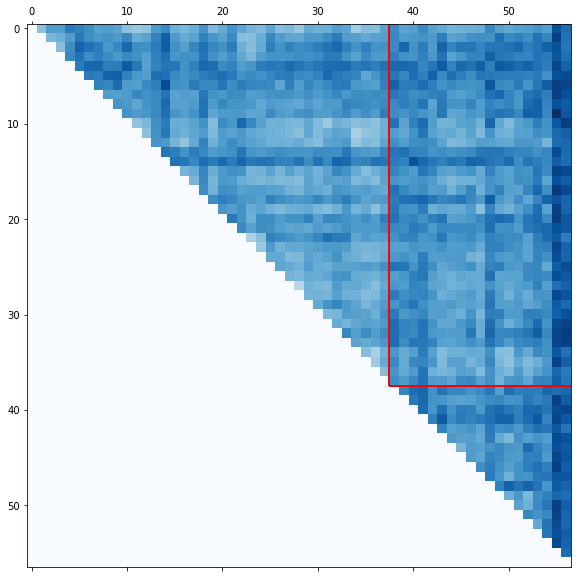

Query 2


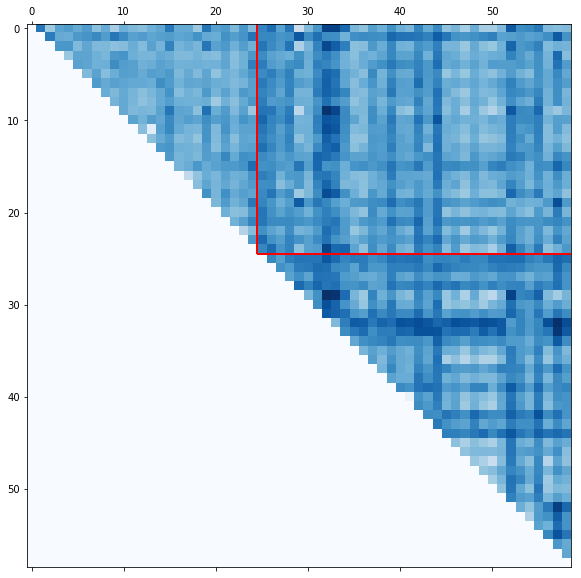

Query 3


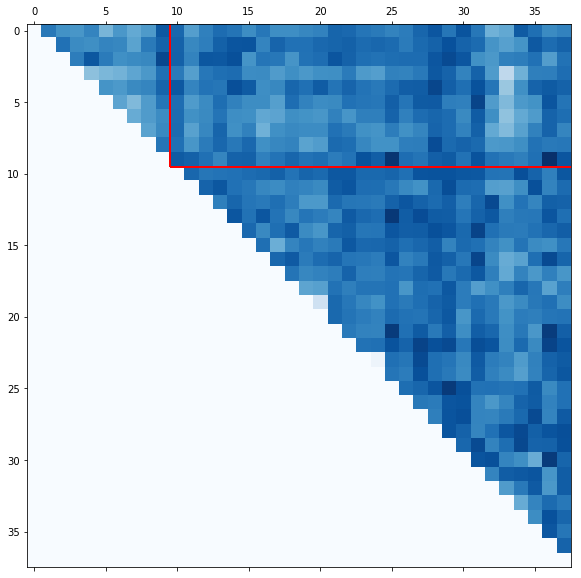

Query 4


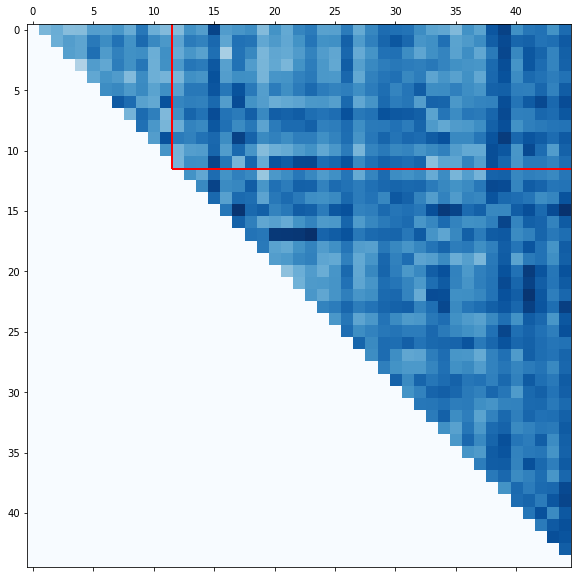

Query 5


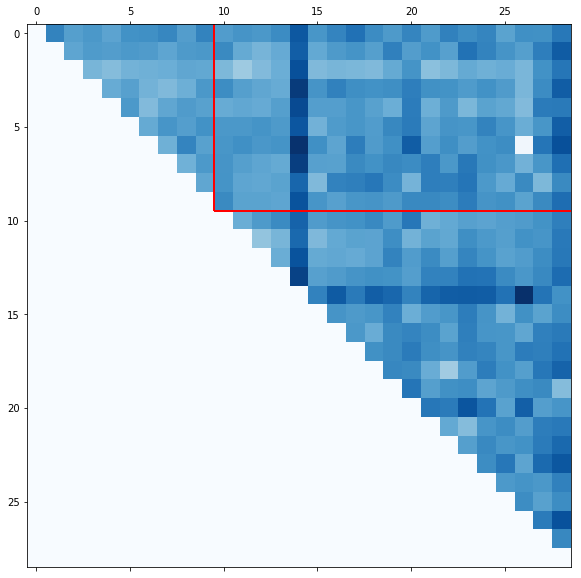

Query 6


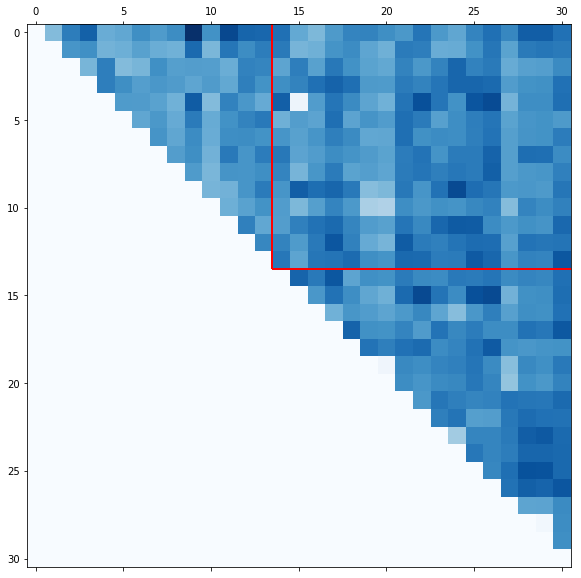

Query 7


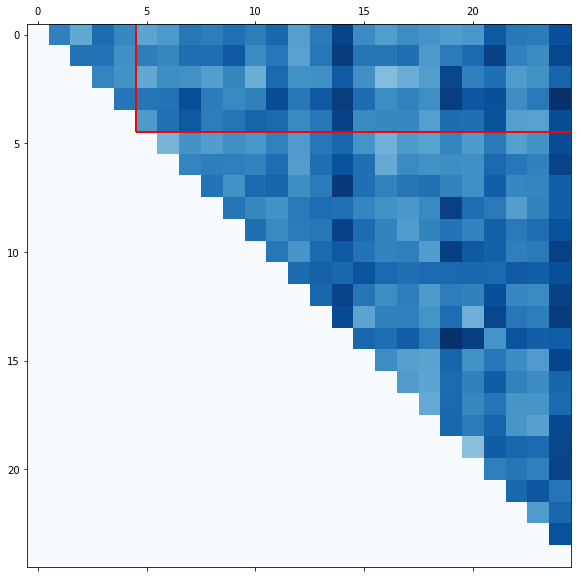

Query 8


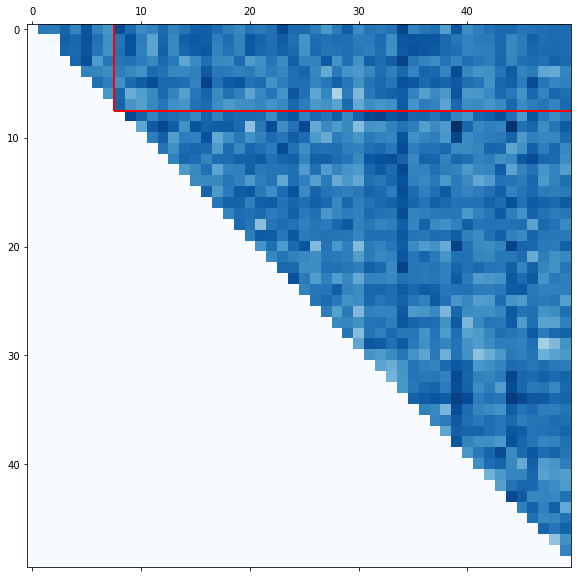

Query 9


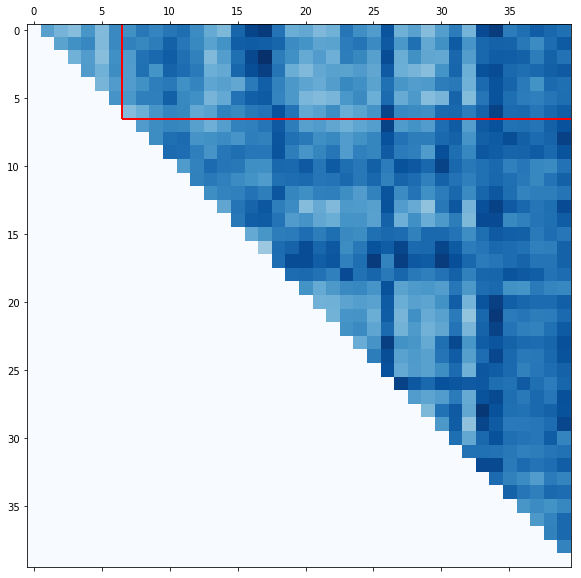

Query 10


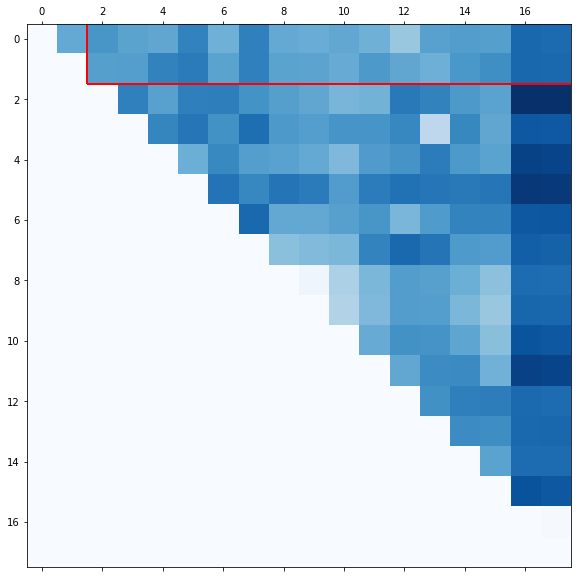

CPU times: user 38.3 s, sys: 2.59 s, total: 40.9 s
Wall time: 37.8 s


In [20]:
%%time
for query in xrange(1, 11):
    sim_matrix(query, gm.cossim)

In [24]:
from scipy.spatial.distance import cosine
def get_scores(query):
    xx = 0
    scores = []
    i = 0
    query = model.infer_vector(query, steps=1000)
    for x in range(0,dictionary.num_docs):
        score = 1 - cosine(model.docvecs[x], query)
        scores.append(score)
    return scores

In [25]:
%%time
results = copy.deepcopy(query_truth)

sim_list = [0]
rank_list = [0]
queries = [0]
for i,query in enumerate(files_to_tokens('LegalAdhocTask/q*.txt')):
    queries.append(query)
    sims = get_scores(query)
    sim_list.append(sims)
    # rank of every document wrt similarity
    ranks = rankdata(sims, method='ordinal')
    ranks= len(ranks)+1 - ranks 
    rank_list.append(ranks)
    
    # update the query truth tuples with similarity score and the ranks
    for x in results[str(i+1)]:
        x.append(sims[filenames.index(x[0]+'.txt')])
        x.append(ranks[filenames.index(x[0]+'.txt')])
    print i
        

0
1
2
3
4
5
6
7
8
9
CPU times: user 1min 31s, sys: 48 ms, total: 1min 31s
Wall time: 1min 31s


In [26]:
results

{'1': [['ConsumerCourt_DCDRC_100385', '1', 0.25792929681718135, 163148],
  ['ConsumerCourt_DCDRC_107608', '1', 0.2165686771669576, 205748],
  ['ConsumerCourt_DCDRC_114291', '1', 0.15980590661320049, 274062],
  ['ConsumerCourt_DCDRC_114382', '1', 0.19551234293630815, 230407],
  ['ConsumerCourt_DCDRC_118185', '1', 0.18196504100973865, 247137],
  ['ConsumerCourt_DCDRC_130570', '1', 0.23313272610431079, 187507],
  ['ConsumerCourt_DCDRC_131146', '1', 0.16969792309152398, 262086],
  ['ConsumerCourt_DCDRC_131717', '1', 0.15372878228782161, 281250],
  ['ConsumerCourt_DCDRC_131741', '1', 0.15556240918143183, 279102],
  ['ConsumerCourt_DCDRC_131818', '1', 0.13685450235599661, 299590],
  ['ConsumerCourt_DCDRC_133592', '1', 0.29573614317733077, 132511],
  ['ConsumerCourt_DCDRC_135474', '1', 0.29689080576152038, 131672],
  ['ConsumerCourt_DCDRC_140039', '1', 0.27183495180637807, 151033],
  ['ConsumerCourt_DCDRC_187214', '1', 0.2177436691276875, 204417],
  ['ConsumerCourt_DCDRC_207784', '1', 0.18810